In [1]:
import numpy as np
import cv2
import os
# import pandas as pd
# from PIL import Image
# import h5py
import matplotlib.pyplot as plt
# from scipy import io
# from time import time
import sys
from sklearn.model_selection import train_test_split
from helper_functions.data import write_h5, read_h5_numpy
# from helper_funciton.general import touch_dir
from typing import List, Optional
import requests
# import io
import gzip
# import shutil
from pathlib import Path
from tqdm import tqdm

from torch.utils.data import DataLoader
import torch

print(os.getcwd())

/Users/matte/Documents/RESEARCH/PyTorch-Lightning-template/notebooks


In [2]:

def download_dataset(
        url, 
        labels = False):
    try:
        r = requests.get(url, stream=True)
    except:
        r = requests.get(url, stream=True, verify=False)

    if labels == False:
        out = np.frombuffer(
            gzip.decompress(r.content), 
            dtype=np.uint8,
            offset=16)
        out = out.reshape(int(out.shape[0]/784), 784)
    else:
        out = np.frombuffer(
            gzip.decompress(r.content), 
            dtype=np.uint8,
            offset=8)
        
    return out


### Train dataset
print(' Downloading and extracting train images ...')
images_train = download_dataset(
    url = "http://fashion-mnist.s3-website.eu-central-1.amazonaws.com/train-images-idx3-ubyte.gz"
)

print(' Downloading and extracting train labels ...')
labels_train = download_dataset(
    url = "http://fashion-mnist.s3-website.eu-central-1.amazonaws.com/train-labels-idx1-ubyte.gz",
    labels = True
)


### Test dataset
print(' Downloading and extracting test images ...')
images_test = download_dataset(
    url = "http://fashion-mnist.s3-website.eu-central-1.amazonaws.com/t10k-images-idx3-ubyte.gz"
)

print(' Downloading and extracting test labels ...')
labels_test = download_dataset(
    url = "http://fashion-mnist.s3-website.eu-central-1.amazonaws.com/t10k-labels-idx1-ubyte.gz",
    labels = True
)



In [3]:
def reshape_and_resize_images(
        X : np.ndarray,
        new_dims : Optional[List] = None,
        ) -> np.ndarray:
    
    dims = X.shape
    dims = [int(x) for x in [dims[0], np.sqrt(dims[1]), np.sqrt(dims[1])]]
    X = X.reshape(dims).astype(np.uint8)

    if new_dims is not None:

        X_proc = np.zeros((
            X.shape[0],
            new_dims[0],
            new_dims[1]),
            np.uint8)

        print('Resizing images ...')
        for i in range(X.shape[0]):
            if i/10000 == i//10000:
                print('   -> Step {} of {}'.format(i,X.shape[0]))
            x = X[i,...]
            if new_dims != x.shape[0]:
                x = cv2.resize(
                    x.astype(np.uint8), 
                    dsize=(new_dims[0],new_dims[1]), 
                    interpolation=cv2.INTER_CUBIC
                    )
            X_proc[i,...] = x

        print('Done resizing!')

    else:
        X_proc = X

    return X_proc

In [4]:
new_dims = [125,125]

X_proc = reshape_and_resize_images(
    images_train,
    new_dims = new_dims
    )

###
X_train, X_val, y_train, y_val = train_test_split(
    X_proc,labels_train,
    test_size=.15,
    shuffle=True,
    random_state=42
)

dict_train = {
    'X' : X_train,
    'y' : y_train,
}

dict_val = {
    'X' : X_val,
    'y' : y_val,
}



Resizing images ...
   -> Step 0 of 60000
   -> Step 10000 of 60000
   -> Step 20000 of 60000
   -> Step 30000 of 60000
   -> Step 40000 of 60000
   -> Step 50000 of 60000
Done resizing!


In [5]:
### Save the entire dataset
verbose = True

print(' Saving entire train dataset ...')
write_h5(
    data = dict_train,
    filename='../data/fashion-mnist_{}x{}_train'.format(X_proc.shape[1], X_proc.shape[2]),
    dtype=np.uint8,
    verbose = True
    )

print(' Saving entire val dataset ...')
write_h5(
    data = dict_val,
    filename='../data/fashion-mnist_{}x{}_val'.format(X_proc.shape[1], X_proc.shape[2]),
    dtype=np.uint8,
    verbose = True
    )




# batch_size = 64


# batch_size = 64
# dataset = DataLoader(
#     list(zip(
#         torch.tensor(dict_train['X'], dtype = torch.float32),
#         torch.tensor(dict_train['y'], dtype = torch.float64),
#         )),
#     batch_size = batch_size,
#     shuffle = True,
#     drop_last = True,
# )

# for i, (Xi,yi) in enumerate(dataset):
#     print('Saving training batch {} of {}'.format(
#         i, len(dataset)
#     ))
#     write_h5(
#         data = {'X' : Xi, 'y' : yi},
#         filename='../data/fashion-mnist/train/batch_{}'.format(i),
#         dtype=np.float32,
#         verbose = False)
    

 Saving entire train dataset ...
Processing key: X, dims: (51000, 125, 125), size: 796.88MB
Processing key: y, dims: (51000,), size: 0.05MB
 -> DonE! Elapsed time: 2.907s, final size: 441.93MB
 Saving entire val dataset ...
Processing key: X, dims: (9000, 125, 125), size: 140.63MB
Processing key: y, dims: (9000,), size: 0.01MB
 -> DonE! Elapsed time: 0.494s, final size: 77.91MB


In [6]:
def touch_dir(dir_path: str) -> None:
    """
    Create dir if not exist
    :param dir_path: directory path
    """
    Path(dir_path).mkdir(parents=True, exist_ok=True)

def batch_and_save_data(data,filename,batch_size):
    touch_dir(filename)

    batch_indices = DataLoader(
        np.arange(data['y'].shape[0]),
        batch_size = batch_size,
        shuffle = True,
        drop_last = True,
    )


    for i, indices in enumerate(tqdm(
        batch_indices, 
        total=len(batch_indices), 
        miniters=len(batch_indices)//10)
        ):
        # print('Saving training batch {} of {}'.format(
        #     i, len(dataset)
        # ))
        write_h5(
            data = {
                'X' : data['X'][indices, ...], 
                'y' : data['y'][indices, ...]},
            filename=filename + '/batch_{}'.format(i),
            dtype=np.float32,
            verbose = False,
            chunk_1st_dim = 1
            )


In [7]:
### Save batched dataset
batch_size = 64

print(' Saving train dataset in batches ...')
batch_and_save_data(
    data = dict_train, 
    filename = '../data/fashion-mnist-resized/train/',
    batch_size = batch_size
    )

print(' Saving val dataset in batches ...')
batch_and_save_data(
    data = dict_val, 
    filename = '../data/fashion-mnist-resized/val/',
    batch_size = batch_size
    )



 Saving train dataset in batches ...


  0%|          | 0/796 [00:00<?, ?it/s]

100%|██████████| 796/796 [00:05<00:00, 145.51it/s]


 Saving val dataset in batches ...


100%|██████████| 140/140 [00:00<00:00, 148.07it/s]


In [8]:
X_proc = reshape_and_resize_images(
    images_test,
    new_dims = new_dims
    )

###
dict_test = {
    'X' : X_proc,
    'y' : labels_test,
}

verbose = True

write_h5(
    data = dict_test,
    filename='../data/fashion-mnist_{}x{}_test'.format(X_proc.shape[1], X_proc.shape[2]),
    dtype=np.int8,
    verbose = verbose
    )



Resizing images ...
   -> Step 0 of 10000
Done resizing!
Processing key: X, dims: (10000, 125, 125), size: 156.25MB
Processing key: y, dims: (10000,), size: 0.00MB
 -> DonE! Elapsed time: 0.460s, final size: 49.08MB


In [9]:
### Save batched dataset
print(' Saving test dataset in batches ...')
batch_and_save_data(
    data = dict_test, 
    filename = '../data/fashion-mnist-resized/test/',
    batch_size = batch_size
    )



 Saving test dataset in batches ...


100%|██████████| 156/156 [00:01<00:00, 142.64it/s]


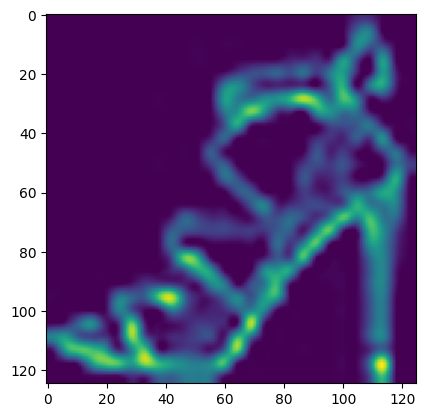

In [10]:
data_load = read_h5_numpy(
    filename='../data/fashion-mnist_{}x{}_train.h5'.format(X_proc.shape[1], X_proc.shape[2])
)

ind = 1000
# ind = 1001

plt.imshow(data_load['X'][ind,:,:])
plt.show()
